<a href="https://colab.research.google.com/github/mHasNain084/Railway-management-system/blob/main/Stocks_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
# IMPORTING THE DATA OF A COMAPNY FROM YAHOO FINANCE

# Create a Ticker object
apple = yf.Ticker("AAPL")

# Get full available history from earliest date to today
data = apple.history(period="max")  # Use period="max" to get all available data
data.reset_index(inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-12-12 00:00:00-05:00,0.098597,0.099025,0.098597,0.098597,469033600,0.0,0.0
1,1980-12-15 00:00:00-05:00,0.093881,0.093881,0.093453,0.093453,175884800,0.0,0.0
2,1980-12-16 00:00:00-05:00,0.087022,0.087022,0.086594,0.086594,105728000,0.0,0.0
3,1980-12-17 00:00:00-05:00,0.088737,0.089165,0.088737,0.088737,86441600,0.0,0.0
4,1980-12-18 00:00:00-05:00,0.091310,0.091738,0.091310,0.091310,73449600,0.0,0.0


In [3]:
data.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
11245,2025-07-28 00:00:00-04:00,214.029999,214.850006,213.059998,214.050003,37858000,0.0,0.0
11246,2025-07-29 00:00:00-04:00,214.179993,214.809998,210.820007,211.270004,51411700,0.0,0.0
11247,2025-07-30 00:00:00-04:00,211.899994,212.389999,207.720001,209.050003,45512500,0.0,0.0
11248,2025-07-31 00:00:00-04:00,208.490005,209.839996,207.160004,207.570007,80698400,0.0,0.0
11249,2025-08-01 00:00:00-04:00,210.869995,213.580002,201.500000,202.380005,104301700,0.0,0.0


In [4]:
data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,11250.000000,11250.000000,11250.000000,11250.000000,1.125000e+04,11250.000000,11250.000000
mean,25.880976,26.163591,25.614262,25.900965,3.121527e+08,0.000825,0.001511
std,53.777281,54.363920,53.236826,53.828433,3.340030e+08,0.012553,0.082721
min,0.038153,0.038153,0.037724,0.037724,0.000000e+00,0.000000,0.000000
25%,0.244573,0.250295,0.239494,0.244739,1.084566e+08,0.000000,0.000000
50%,0.461041,0.468090,0.454655,0.462622,2.007208e+08,0.000000,0.000000
75%,20.316740,20.417521,20.127585,20.292535,3.916731e+08,0.000000,0.000000
max,257.568678,259.474086,257.010028,258.396667,7.421641e+09,0.260000,7.000000


In [5]:
dataForProphet = pd.DataFrame(data[0:int(len(data)*0.9)])
test_data = pd.DataFrame(data[int(len(data)*0.9):int(len(data))])

dataForProphet.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
10120,2021-02-02 00:00:00-05:00,132.404876,132.970669,131.312318,131.683014,83305400,0.000,0.0
10121,2021-02-03 00:00:00-05:00,132.434112,132.443877,130.336789,130.658707,89880900,0.000,0.0
10122,2021-02-04 00:00:00-05:00,132.960922,134.033965,131.292807,134.024216,84183100,0.000,0.0
10123,2021-02-05 00:00:00-05:00,134.185380,134.253760,132.729706,133.608963,75693800,0.205,0.0
10124,2021-02-08 00:00:00-05:00,132.895810,133.804390,131.811384,133.755539,71297200,0.000,0.0


In [6]:
test_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
10125,2021-02-09 00:00:00-05:00,133.472228,134.703206,132.719980,132.876282,76774200,0.0,0.0
10126,2021-02-10 00:00:00-05:00,133.335421,133.833679,131.303343,132.270538,73046600,0.0,0.0
10127,2021-02-11 00:00:00-05:00,132.768835,133.247550,130.687920,132.016586,64280000,0.0,0.0
10128,2021-02-12 00:00:00-05:00,131.254504,132.407309,130.609707,132.250992,60145100,0.0,0.0
10129,2021-02-16 00:00:00-05:00,132.368256,132.876265,129.730454,130.121246,80576300,0.0,0.0


In [7]:
dataForProphet.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,10125.000000,10125.000000,10125.000000,10125.000000,1.012500e+04,10125.000000,10125.000000
mean,9.446239,9.548802,9.342059,9.449358,3.389757e+08,0.000520,0.001679
std,19.644278,19.877521,19.403174,19.650779,3.415597e+08,0.009024,0.087194
min,0.038153,0.038153,0.037724,0.037724,0.000000e+00,0.000000,0.000000
25%,0.225406,0.229773,0.220297,0.225406,1.303916e+08,0.000000,0.000000
50%,0.363055,0.370223,0.356040,0.362826,2.265088e+08,0.000000,0.000000
75%,9.887525,9.984898,9.770615,9.841545,4.218284e+08,0.000000,0.000000
max,140.082025,141.535569,137.906645,139.652802,7.421641e+09,0.205000,7.000000


In [8]:
test_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1125.000000,1125.000000,1125.000000,1125.000000,1.125000e+03,1125.000000,1125.0
mean,173.793613,175.696689,172.064089,173.965427,7.074580e+07,0.003573,0.0
std,33.713634,33.947833,33.488022,33.755321,2.942228e+07,0.028901,0.0
min,116.287484,117.625916,113.532455,113.679001,2.323470e+07,0.000000,0.0
25%,146.022901,147.487288,144.590307,146.136978,4.970930e+07,0.000000,0.0
50%,169.841456,171.661279,168.661039,170.102692,6.455610e+07,0.000000,0.0
75%,194.779097,197.699997,193.413605,195.973480,8.491430e+07,0.000000,0.0
max,257.568678,259.474086,257.010028,258.396667,3.186799e+08,0.260000,0.0


In [9]:
# CONVERTING THE TEST DATA (dataForProphet) INTO A NEW FORMAT ACCEPTED BY PROPHET

dataForProphet = dataForProphet[['Date', 'High']]
dataForProphet.columns = ['ds', 'y']
dataForProphet['ds'] = dataForProphet['ds'].dt.tz_localize(None)
dataForProphet.head()

/tmp/ipython-input-2983300102.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataForProphet['ds'] = dataForProphet['ds'].dt.tz_localize(None)


,ds,y
0,1980-12-12,0.099025
1,1980-12-15,0.093881
2,1980-12-16,0.087022
3,1980-12-17,0.089165
4,1980-12-18,0.091738


In [10]:
# USING BUILT-IN PROPHET MODEL TO DETECT THE TREND IN THE STOCK PRICE OVER TIME

prophetModel = Prophet()
prophetModel.fit(dataForProphet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6d00zuq7/lzklct9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6d00zuq7/qatgy5qb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80613', 'data', 'file=/tmp/tmp6d00zuq7/lzklct9b.json', 'init=/tmp/tmp6d00zuq7/qatgy5qb.json', 'output', 'file=/tmp/tmp6d00zuq7/prophet_model9a9b91dl/prophet_model-20250804105102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
# Predict the next 60 days
future = prophetModel.make_future_dataframe(periods=60, freq='D')

In [12]:
# Forecast
forecast = prophetModel.predict(future)
forecast = forecast[['ds', 'yhat']]
forecast = pd.DataFrame(forecast)
forecast.head()

,ds,yhat
0,1980-12-12,0.566997
1,1980-12-15,0.703704
2,1980-12-16,0.690358
3,1980-12-17,0.702955
4,1980-12-18,0.711159


In [13]:
forecast.describe()

,ds,yhat
count,10185,10185.000000
mean,2001-02-13 23:38:39.057437440,9.950513
min,1980-12-12 00:00:00,-0.853814
25%,1991-01-09 00:00:00,0.042024
50%,2001-02-06 00:00:00,0.839208
75%,2011-03-23 00:00:00,7.719635
max,2021-04-09 00:00:00,78.347824
std,NaN,19.308102


In [14]:
# Merge predicted and actual data
merged = pd.merge(forecast[['ds', 'yhat']], dataForProphet, on='ds', how='left')

In [15]:
# Compute error only where actual price is known

merged['error'] = merged['yhat'] - merged['y']
merged.head()

,ds,yhat,y,error
0,1980-12-12,0.566997,0.099025,0.467972
1,1980-12-15,0.703704,0.093881,0.609822
2,1980-12-16,0.690358,0.087022,0.603335
3,1980-12-17,0.702955,0.089165,0.613790
4,1980-12-18,0.711159,0.091738,0.619421


In [16]:
merged.describe()

,ds,yhat,y,error
count,10185,10185.000000,10125.000000,10125.000000
mean,2001-02-13 23:38:39.057437440,9.950513,9.548802,0.000044
min,1980-12-12 00:00:00,-0.853814,0.038153,-63.407521
25%,1991-01-09 00:00:00,0.042024,0.229773,-0.653127
50%,2001-02-06 00:00:00,0.839208,0.370223,0.147811
75%,2011-03-23 00:00:00,7.719635,9.984898,0.624222
max,2021-04-09 00:00:00,78.347824,141.535569,24.519449
std,NaN,19.308102,19.877521,6.774800


In [17]:
# Create interactive plot with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

In [18]:
# Plot predicted price
fig.add_trace(go.Scatter(
    x=merged['ds'], y=merged['yhat'], mode='lines',
    name='Predicted Price', line=dict(color='blue')
), secondary_y=False)

# Plot actual price
fig.add_trace(go.Scatter(
    x=merged['ds'], y=merged['y'], mode='lines',
    name='Actual Price', line=dict(color='green')
), secondary_y=False)

# Customize layout
fig.update_layout(
    title='📊 Actual vs Predicted Stock Price with Prediction Error (AAPL)',
    xaxis_title='Date',
    yaxis_title='Stock Price (USD)',
    height=650,
    legend=dict(x=0.01, y=0.99)
)

fig.show()

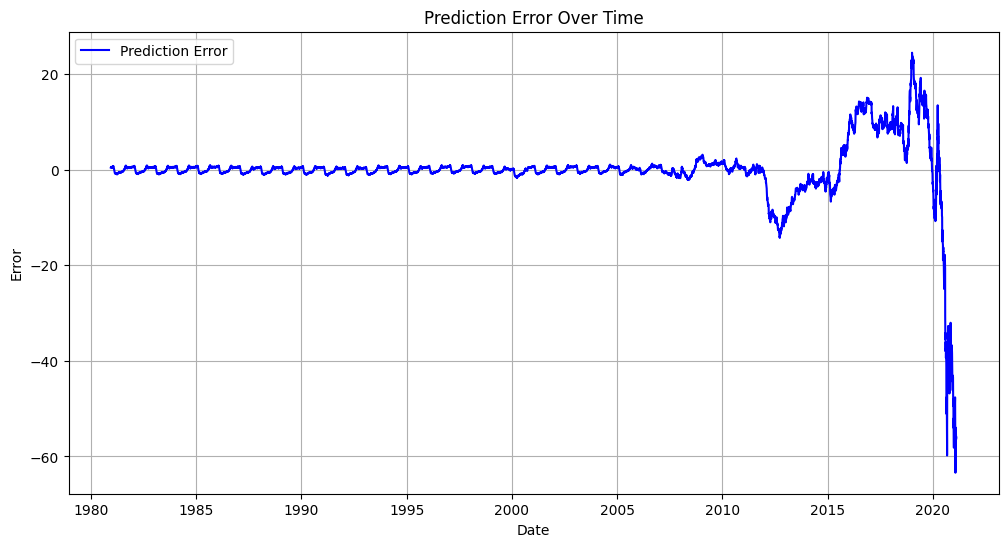

In [19]:
# plotting the error between predicted and actual value using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(merged['ds'], merged['error'], label='Prediction Error', color='blue')
plt.title('Prediction Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# DROP LAST 60 ROWS OF MERGED DATASET BECAUSE yhat HAS 60 EXTRA ENTRIES
# FOR THE PREDICTION FROM PROPHET MODEL AGAINST THE NULL VALUES OF y

LSTM_data = merged[['error']].iloc[:-60]
LSTM_data.head()

,error
0,0.467972
1,0.609822
2,0.603335
3,0.613790
4,0.619421


In [21]:
LSTM_data.tail()

,error
10120,-54.947027
10121,-54.451975
10122,-56.080501
10123,-56.424136
10124,-56.020873


In [22]:
LSTM_data.describe()

,error
count,10125.000000
mean,0.000044
std,6.774800
min,-63.407521
25%,-0.653127
50%,0.147811
75%,0.624222
max,24.519449


In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(LSTM_data)

In [24]:
scaled_data.shape

(10125, 1)

In [25]:
LSTM_train = merged[0:int(len(scaled_data)*0.9)]
LSTM_test = merged[int(len(scaled_data)*0.9):int(len(scaled_data))]

print(f"train_shape: {LSTM_train.shape}")
print(f"test_shape: {LSTM_test.shape}")

train_shape: (9112, 4)
test_shape: (1013, 4)


In [26]:
WINDOW_SIZE = 30

In [27]:
def data_to_input_and_output(data):

    input_data = []
    output_data = []
    for index in range(0, len(data) - WINDOW_SIZE):
        input_sample = data['error'][index:index + WINDOW_SIZE].values
        output_sample = data['error'].iloc[index + WINDOW_SIZE]

        input_data.append(input_sample)
        output_data.append(output_sample)

    return np.array(input_data), np.array(output_data)

In [28]:
train_input, train_output = data_to_input_and_output(LSTM_train)
test_input, test_output = data_to_input_and_output(LSTM_test)

In [29]:
def train_neural_network(X, y, epochs=7, learning_rate=0.005):

    model = Sequential()
    model.add(InputLayer((WINDOW_SIZE, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    check_point = ModelCheckpoint('model/.keras', save_best_only=True, monitor='loss')
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

    model.fit(X, y, epochs=epochs, callbacks=[check_point])
    return model

In [31]:
model = train_neural_network(train_input, train_output)

model = load_model('model/.keras')

Epoch 1/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1.9877 - root_mean_squared_error: 1.2836
Epoch 2/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0384 - root_mean_squared_error: 0.1958
Epoch 3/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0399 - root_mean_squared_error: 0.1991
Epoch 4/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0240 - root_mean_squared_error: 0.1546
Epoch 5/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0241 - root_mean_squared_error: 0.1549
Epoch 6/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0353 - root_mean_squared_error: 0.1862
Epoch 7/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502


In [32]:
train_pred = model.predict(train_input)
test_pred = model.predict(test_input)

284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [33]:
def plot_predictions(pred, y_true, label, period):
    # Convert period to datetime if it's not already
    period = pd.to_datetime(period)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(period, y_true, label='True Values', color='black')
    plt.plot(period, pred, label='Predictions', color='red')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Target Value (Error in prophet prediction)')
    plt.title(label)

    # Adding legend
    plt.legend()

    # Rotate x-axis labels for better visibility
    plt.gcf().autofmt_xdate()

    # Show the plot
    plt.show()

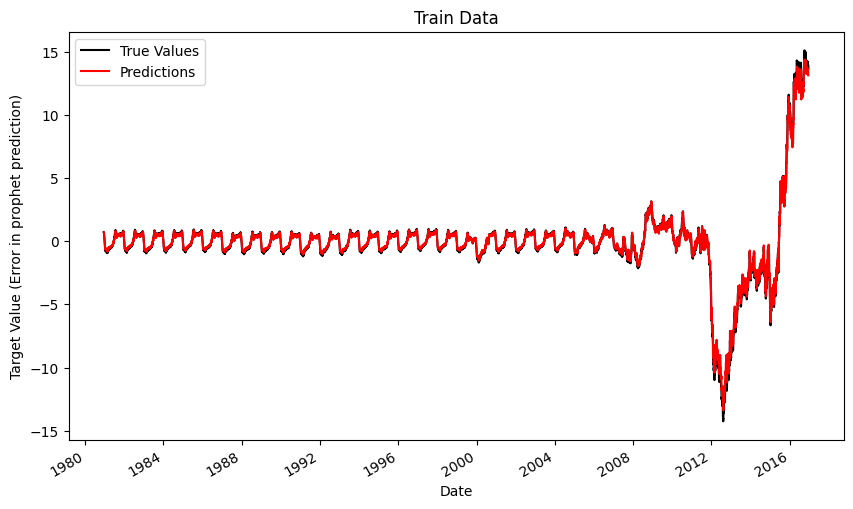

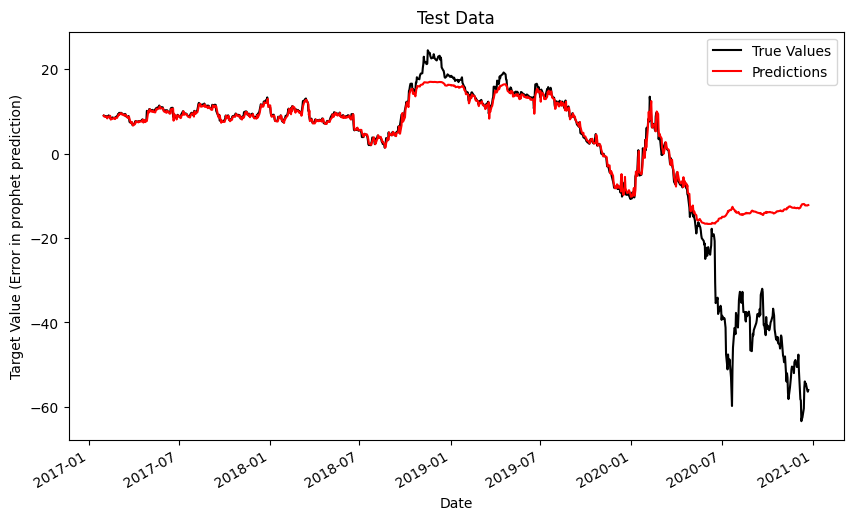

In [34]:
train_period = LSTM_train[0:len(LSTM_train) - WINDOW_SIZE]['ds']
test_period = LSTM_test[0:len(LSTM_test) - WINDOW_SIZE]['ds']

plot_predictions(train_pred, train_output, 'Train Data', train_period)
plot_predictions(test_pred, test_output, 'Test Data', test_period)
predictions = []

In [35]:
def predict_the_future(input_seq, period_prediction: int = 7):
    if period_prediction == 0:
        return None
    new_prediction = model.predict(input_seq)
    predictions.append(new_prediction[0][0])

    new_seq = np.array([np.concatenate((input_seq[0][1:WINDOW_SIZE], new_prediction[0]))])

    predict_the_future(new_seq, period_prediction - 1)

In [36]:
seq_start = LSTM_data[int(len(LSTM_data)-30):].values

# if len(seq_start[0]) != WINDOW_SIZE:
#     raise "Size mismatch"
predict_the_future(seq_start)

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[np.float32(-5.538392),
 np.float32(-3.9506845),
 np.float32(-3.1765165),
 np.float32(-2.697729),
 np.float32(-2.3655343),
 np.float32(-2.119032),
 np.float32(-1.9280269)]